# Projet data mining  
#### Sujet : Analyse et prédiction de l'absenteisme au travail.
###### BUT SD 23-24

Algassimou DIALLO

# Plan
1. [Introduction](#introduction)
2. [Prétraitement des données](#datapreprocessing)
3. [Exploratory Data Analysis](#EDA)
4. [Analyse en composantes principales](#PCA)
4. [Models](#models)
5. [Conclusion](#conclusion)


### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

<a name="datapreprocessing"></a>
# Prétraitement des données

In [2]:
df = pd.read_csv("Absenteeism_at_work.csv", sep =";")
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


- Nous avons 740 observations de 20 variables 
- Pas de NA dans les variables
- Les types des variables semblent correctes.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [4]:
df.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,...,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,18.017568,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,...,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,11.021247,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,...,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,9.000000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,...,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,...,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


On remarque des "min = 0" pour "Reason for absence" et "Month of absence" ce qui est bizarre comparé à la documentation du dataset.

 - Pour la variable "Reason for absence" on remarque que ces valeurs nulles correspondent à une "non absence"(l'individu n'a pas été absent) car on remarque que ces individus ont tous un taux d'absence nulle. Ces informations sont très importantes, ce ne sont pas des erreurs donc on doit garder ces lignes.

In [5]:
df[df["Reason for absence"] ==0]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
50,20,0,9,2,4,260,50,11,36,241.476,...,1,1,4,1,0,0,65,168,23,0
51,29,0,9,2,4,225,26,9,28,241.476,...,1,1,1,0,0,2,69,169,24,0
54,11,0,9,3,4,289,36,13,33,241.476,...,1,1,2,1,0,1,90,172,30,0
55,36,0,9,3,4,118,13,18,50,241.476,...,1,1,1,1,0,0,98,178,31,0
58,13,0,9,4,4,369,17,12,31,241.476,...,1,1,3,1,0,0,70,169,25,0
64,36,0,10,4,4,118,13,18,50,253.465,...,1,1,1,1,0,0,98,178,31,0
203,2,0,4,2,3,235,29,12,48,326.452,...,1,1,1,0,1,5,88,163,33,0
213,7,0,5,4,3,279,5,14,39,378.884,...,1,1,2,1,1,0,68,168,24,0
214,18,0,5,4,3,330,16,4,28,378.884,...,1,2,0,0,0,0,84,182,25,0


- Pour la variable "month of absence" on remarque que ces individus ont tous un taux d'absence nul et ils ne sont qu'au nombre de 3. 
- On decide donc remplacer ces valeurs par le mois moyen des individus précédants(raison = 0 & taux d'absence = 0). 

In [6]:
df[df["Month of absence"]==0]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0
739,35,0,0,6,3,179,45,14,53,271.219,...,0,1,1,0,0,1,77,175,25,0


In [7]:
df[df["Reason for absence"] ==0].mean()


ID                                  18.046512
Reason for absence                   0.000000
Month of absence                     7.325581
Day of the week                      3.860465
Seasons                              3.162791
Transportation expense             246.604651
Distance from Residence to Work     26.488372
Service time                        12.627907
Age                                 39.604651
Work load Average/day              275.880023
Hit target                          92.441860
Disciplinary failure                 0.930233
Education                            1.116279
Son                                  1.348837
Social drinker                       0.674419
Social smoker                        0.186047
Pet                                  1.046512
Weight                              83.534884
Height                             171.837209
Body mass index                     28.325581
Absenteeism time in hours            0.000000
dtype: float64

 - On remplace donc par le mois de Juillet (7)

In [8]:
df["Month of absence"] = df["Month of absence"].replace([0],7)


<a name="EDA"></a>
# Exploratory Data Analysis 

- Reason for absence & Absenteeism time

On remarque que la raison d'absence la plus fréquente  est la raison 23 ("medical consultation") suivi de 28 ("Dental consultation") et de 13 ("Diseases of the musculoskeletal system and connective tissue")

In [9]:
df.groupby('Reason for absence')['Absenteeism time in hours'].mean()

Reason for absence
0      0.000000
1     11.375000
2     24.000000
3      8.000000
4      4.500000
5      6.333333
6     21.375000
7     10.000000
8      5.333333
9     42.000000
10    11.040000
11    11.423077
12    23.375000
13    15.309091
14     8.789474
15     8.000000
16     2.000000
17     8.000000
18    10.333333
19    18.225000
21     5.833333
22     7.710526
23     2.845638
24     8.000000
25     3.483871
26     7.272727
27     2.275362
28     2.991071
Name: Absenteeism time in hours, dtype: float64

 #### Graphique pour mieux visualiser ces données : 

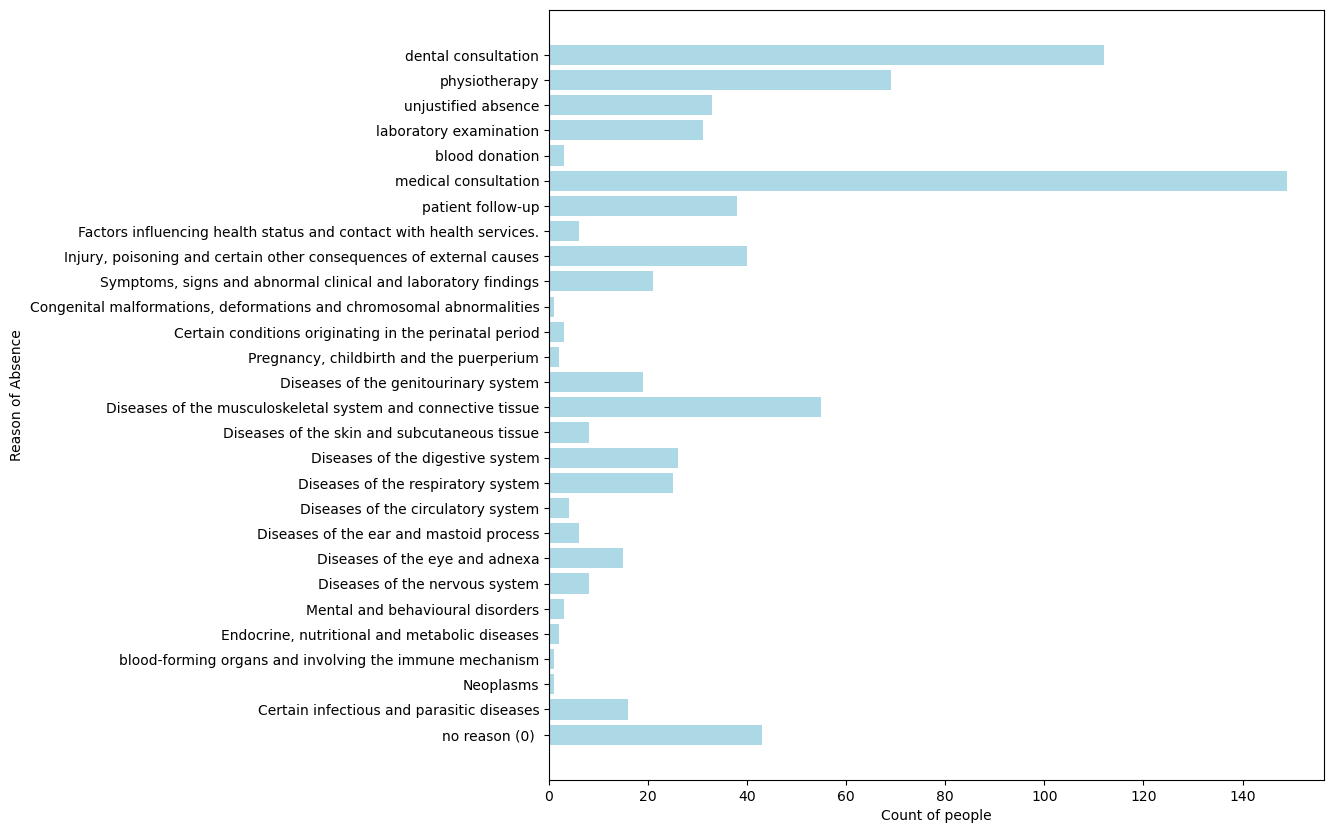

In [10]:
top_raison=df.groupby('Reason for absence')['Absenteeism time in hours'].count()
top_raison=np.array(top_raison) 
fig= plt.subplots(figsize=(10,10))

table=["no reason (0) ",'Certain infectious and parasitic diseases', 'Neoplasms', 'blood-forming organs and involving the immune mechanism', 'Endocrine, nutritional and metabolic diseases', 'Mental and behavioural disorders', 'Diseases of the nervous system', 'Diseases of the eye and adnexa', 'Diseases of the ear and mastoid process', 'Diseases of the circulatory system', 'Diseases of the respiratory system', 'Diseases of the digestive system', 'Diseases of the skin and subcutaneous tissue', 'Diseases of the musculoskeletal system and connective tissue', 'Diseases of the genitourinary system','Pregnancy, childbirth and the puerperium','Certain conditions originating in the perinatal period','Congenital malformations, deformations and chromosomal abnormalities', 'Symptoms, signs and abnormal clinical and laboratory findings', 'Injury, poisoning and certain other consequences of external causes', 'Factors influencing health status and contact with health services.','patient follow-up','medical consultation','blood donation','laboratory examination','unjustified absence','physiotherapy','dental consultation']

plt.barh(y=np.arange(len(top_raison)),width=top_raison,label='No. of people',color='lightblue')
plt.yticks(np.arange(len(top_raison)),table,rotation=0)

plt.ylabel('Reason of Absence')
plt.xlabel('Count of people')
plt.savefig('sample.jpg')

Text(0.5, 0, 'Mean absenteeism time')

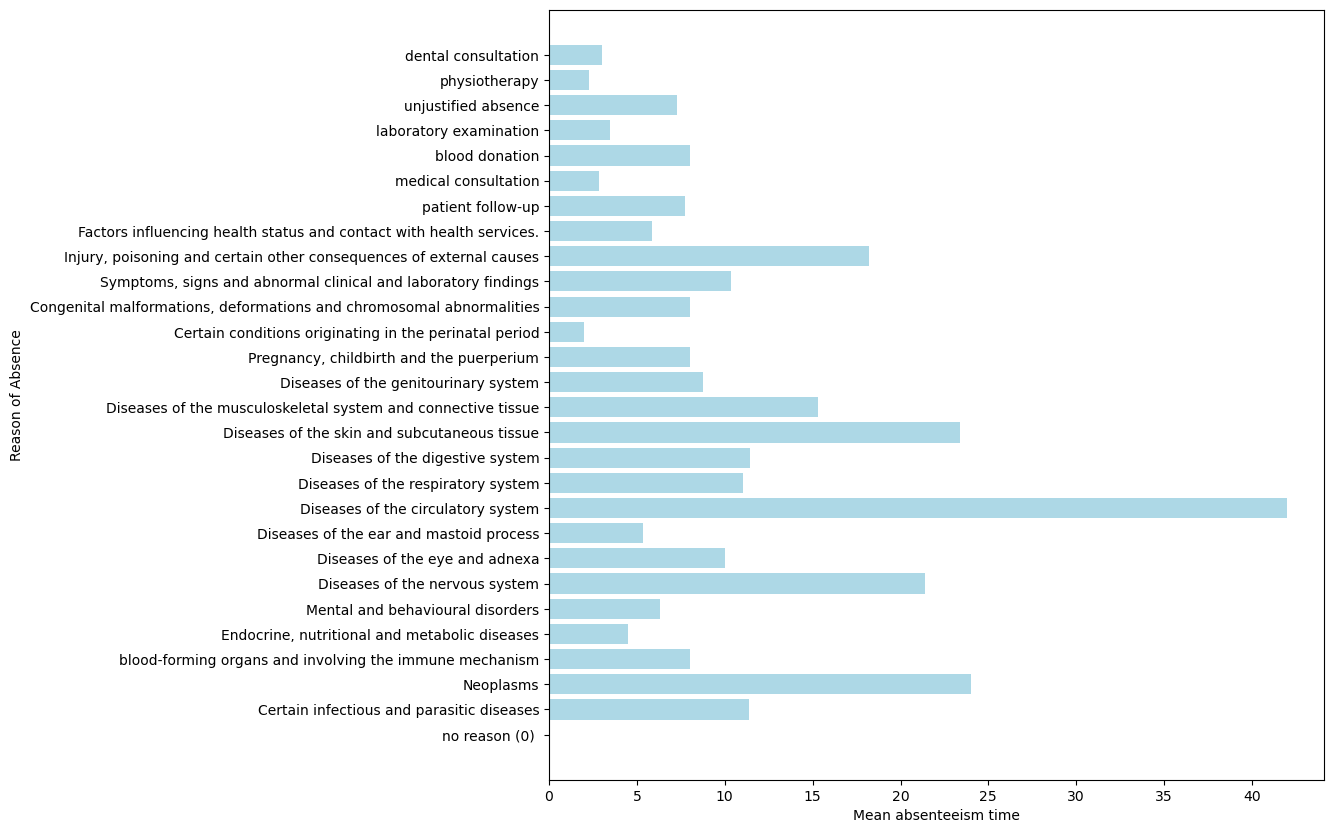

In [11]:
top_raison=df.groupby('Reason for absence')['Absenteeism time in hours'].mean()
top_raison=np.array(top_raison) 
fig= plt.subplots(figsize=(10,10))

table=["no reason (0) ",'Certain infectious and parasitic diseases', 'Neoplasms', 'blood-forming organs and involving the immune mechanism', 'Endocrine, nutritional and metabolic diseases', 'Mental and behavioural disorders', 'Diseases of the nervous system', 'Diseases of the eye and adnexa', 'Diseases of the ear and mastoid process', 'Diseases of the circulatory system', 'Diseases of the respiratory system', 'Diseases of the digestive system', 'Diseases of the skin and subcutaneous tissue', 'Diseases of the musculoskeletal system and connective tissue', 'Diseases of the genitourinary system','Pregnancy, childbirth and the puerperium','Certain conditions originating in the perinatal period','Congenital malformations, deformations and chromosomal abnormalities', 'Symptoms, signs and abnormal clinical and laboratory findings', 'Injury, poisoning and certain other consequences of external causes', 'Factors influencing health status and contact with health services.','patient follow-up','medical consultation','blood donation','laboratory examination','unjustified absence','physiotherapy','dental consultation']

plt.barh(y=np.arange(len(top_raison)),width=top_raison,label='No. of people',color='lightblue')
plt.yticks(np.arange(len(top_raison)),table,rotation=0)

plt.ylabel('Reason of Absence')
plt.xlabel("Mean absenteeism time")

- Month of absence & Absenteeism

Le mois de Mars compte le plus d'absences suivi de Février et Octobre.
Ce qui est compréhensible car le mois de Mars est le mois des "festival" au Brésil.(festival de rio)

In [12]:
df.groupby('Month of absence')['Absenteeism time in hours'].count()

Month of absence
1     50
2     72
3     87
4     53
5     64
6     54
7     70
8     54
9     53
10    71
11    63
12    49
Name: Absenteeism time in hours, dtype: int64

#### Graphique pour mieux visualiser la variation par mois.

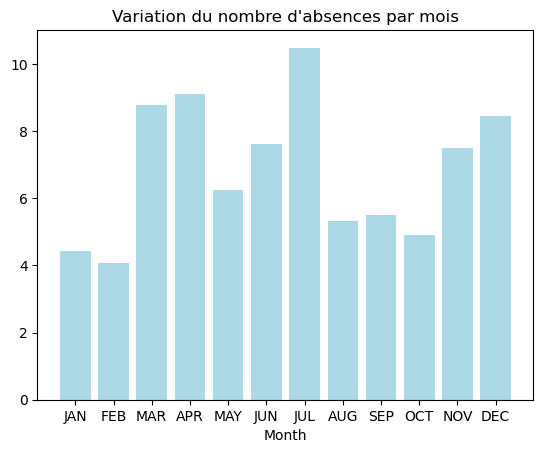

In [13]:
mois_absence = np.array(df.groupby('Month of absence')['Absenteeism time in hours'].mean())


plt.bar(x=np.arange(len(mois_absence)),height=mois_absence ,color='lightblue')
plt.xlabel('Month')
plt.xticks(np.arange(len(mois_absence)),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.title("Variation du nombre d'absences par mois")
plt.show()

- Day of the week & Absenteeism time

Pas de jours particulier. Le nombre d'absence est à peu près le même pour tous les jours de la semaine mais la moyenne est plus elevé le Lundi et très faible le jeudi et le vendredi.

In [14]:
df.groupby('Day of the week')['Absenteeism time in hours'].count()

Day of the week
2    161
3    154
4    156
5    125
6    144
Name: Absenteeism time in hours, dtype: int64

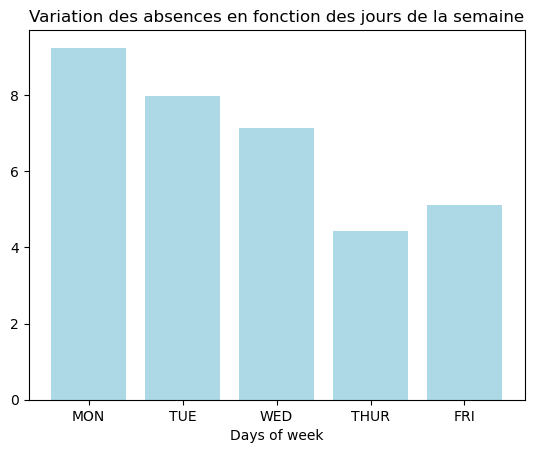

In [15]:
semaines_absence = df.groupby('Day of the week')['Absenteeism time in hours'].mean()
semaines_absence=np.array(semaines_absence)

plt.bar(x=np.arange(len(semaines_absence)),height=semaines_absence,color='lightblue')

plt.xlabel('Days of week')
plt.xticks(np.arange(len(semaines_absence)),['MON','TUE','WED','THUR','FRI'])
plt.title("Variation des absences en fonction des jours de la semaine")
plt.show()

- Son & Absenteeims time

On remarque que les gens avec 2 et 3 enfants ont la durée d'absence moyenne la plus longue.

In [16]:
df.groupby('Son')['Absenteeism time in hours'].mean()


Son
0     5.385906
1     6.030568
2    10.570513
3    12.200000
4     7.285714
Name: Absenteeism time in hours, dtype: float64

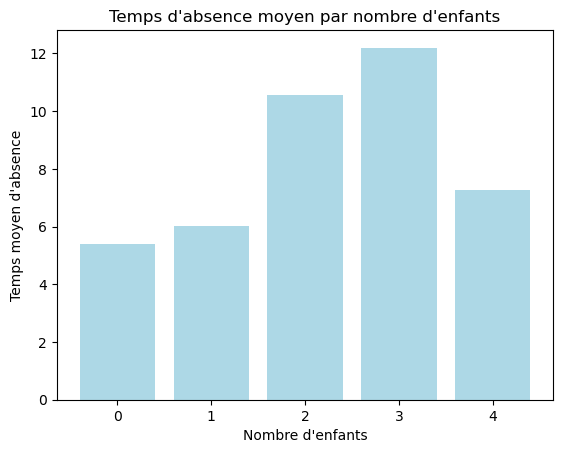

In [17]:
absence_child = np.array(df.groupby('Son')['Absenteeism time in hours'].mean())

plt.bar(x=np.arange(len(absence_child )),height=absence_child  ,color='lightblue')
plt.xlabel("Nombre d'enfants")
plt.ylabel("Temps moyen d'absence")
plt.title("Temps d'absence moyen par nombre d'enfants")
plt.show()

- Social drinker & Absenteeism time

Les fumeurs ont une durée moyenne d'absence plus longue mais la différence est juste d'environ 1h.

In [18]:
df.groupby('Social drinker')['Absenteeism time in hours'].mean()

Social drinker
0    5.931250
1    7.680952
Name: Absenteeism time in hours, dtype: float64

- Social smoket & Absenteeism time

Presque pas de différence

In [19]:
df.groupby('Social smoker')['Absenteeism time in hours'].mean()

Social smoker
0    6.957726
1    6.500000
Name: Absenteeism time in hours, dtype: float64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

- Age & Absenteeism time

Pas de patterns en particuler. On remarque juste un outlier et que les indivdux dans la trentaine ont le temps moyen d'absence le plus elevé.

Text(0.5, 1.0, "Temps d'absence moyen par age")

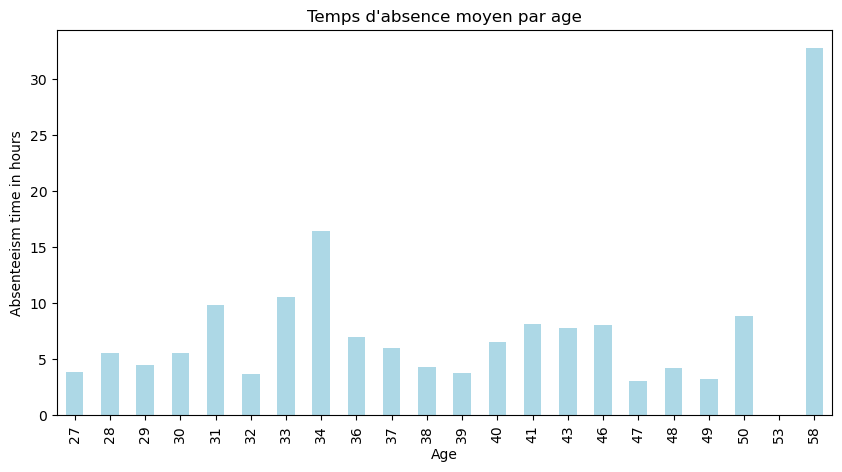

In [21]:
absence_age = df.groupby('Age')['Absenteeism time in hours'].mean()

absence_age.plot(kind='bar', figsize=(10,5), color="lightblue" )
plt.xlabel('Age')
plt.ylabel('Absenteeism time in hours')
plt.title("Temps d'absence moyen par age")



#### Autre manière de visualiser les données

In [22]:
def group_age(age):
    if age >= 0:
        if age % 10 != 0:
            lower = int(math.floor(age/10.0))*10
            upper = int(math.ceil(age/10.0))*10-1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age+9)
            return f"{lower}-{upper}"
        return np.nan 


In [23]:
df1 = df.copy()
df1["age_range"] = df1["Age"].apply(group_age)
age_order=df1['age_range'].unique()




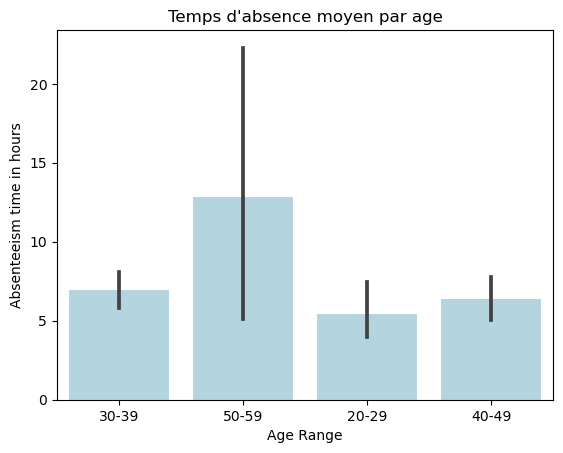

In [24]:

sns.barplot(x='age_range',y='Absenteeism time in hours',data=df1, color="lightblue")
plt.xlabel('Age Range')
plt.ylabel('Absenteeism time in hours')
plt.title("Temps d'absence moyen par age")
plt.show() 



- IMC et Absenteeism time in hours

Pas d'énormes différences, les individus en surpoids ont le temps d'absence moyen le plus élevé.

In [25]:
imc = [0, 18.4, 24.9, 29.9, 39.9]
df1['bmi'] = pd.cut(df['Body mass index'], bins=imc, labels=[f'IMC {i}' for i in range(1, len(imc))])


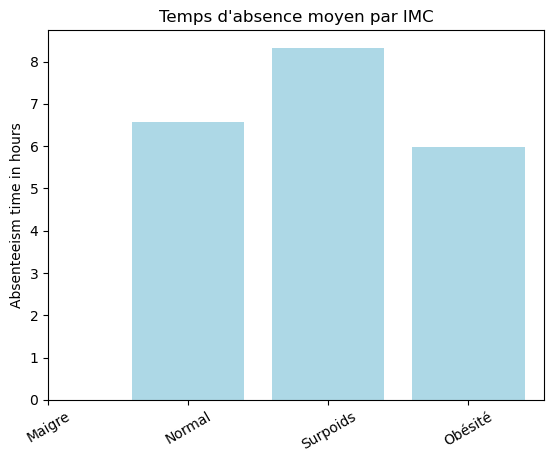

In [26]:
bmi=df1.groupby('bmi')['Absenteeism time in hours'].mean()
plt.bar(x=np.arange(len(bmi)),height=bmi,color='lightblue')
plt.ylabel('Absenteeism time in hours')
plt.xticks(np.arange(len(bmi)),['Maigre','Normal','Surpoids','Obésité'],rotation=30)
plt.title("Temps d'absence moyen par IMC")
plt.show()

### Corrélation des variables

Text(0.5, 1.0, 'Correlation Heatmap')

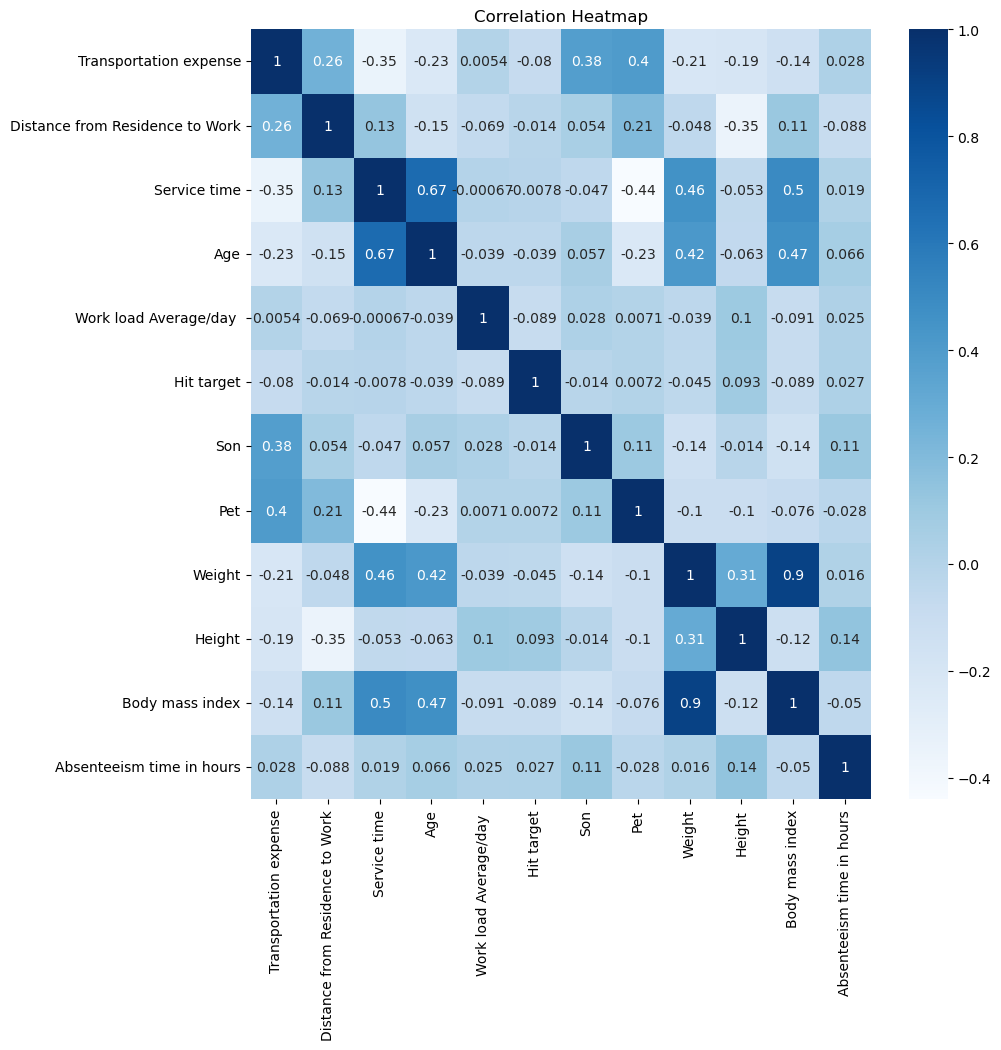

In [27]:
df_corr = df.drop(columns = ['ID', 'Disciplinary failure', 'Social drinker', 'Social smoker', 'Seasons', 
                            'Month of absence', 'Day of the week', 'Reason for absence', 'Education'])
corr = df_corr.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True,cmap='Blues')
plt.title('Correlation Heatmap')

## Transformation des données: Ajout de classe d'absence (retard,normal,absenteiste)

In [28]:
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [29]:

label_encoder = LabelEncoder() 

df = pd.concat([df  ,pd.get_dummies(df  ['Reason for absence'], prefix = 'reason')], axis=1)
df  = pd.concat([df  ,pd.get_dummies(df  ['Day of the week'], prefix = 'day')], axis=1)
df  = pd.concat([df  ,pd.get_dummies(df  ['Seasons'], prefix = 'season')], axis=1)
df = pd.concat([df  ,pd.get_dummies(df  ['Education'], prefix = 'education')], axis=1)



### Meilleur Model RandomForest obtenu

In [30]:
x = df .drop(columns = ['Absenteeism time in hours'])
y = df ['Absenteeism time in hours']
x_train,x_test, y_train,y_test = train_test_split(x,y, train_size = 0.7, random_state = 3)
model = RandomForestClassifier(max_depth=2, random_state=3).fit(x_train,y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_pred,y_test) * 100
print(accuracy)

49.0990990990991


### GridSearch pour avoir le best modèle.

In [31]:
"""param_grid = {
'n_estimators': [200, 500],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,6,7,8],
'criterion' :['gini', 'entropy']
}
grid = GridSearchCV(RandomForestClassifier(),param_grid,verbose = 3)

grid.fit(x_train,y_train)

print(grid.best_params_) """

"param_grid = {\n'n_estimators': [200, 500],\n'max_features': ['auto', 'sqrt', 'log2'],\n'max_depth' : [4,5,6,7,8],\n'criterion' :['gini', 'entropy']\n}\ngrid = GridSearchCV(RandomForestClassifier(),param_grid,verbose = 3)\n\ngrid.fit(x_train,y_train)\n\nprint(grid.best_params_) "

In [32]:
best_model = RandomForestClassifier(criterion = 'gini', max_depth = 7, max_features = 'sqrt', n_estimators = 500 )
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
print("Prediction best_model: \n",y_pred,"\n","Précision du modèle grid: ", accuracy) 

Prediction best_model: 
 [2 8 8 8 2 8 8 8 8 8 2 2 2 4 4 8 2 2 2 8 2 8 1 8 2 8 2 8 2 8 2 8 8 8 8 2 8
 8 8 2 8 2 0 8 8 0 2 2 8 8 2 8 2 8 8 2 2 2 8 4 2 2 8 8 2 8 8 8 2 8 4 8 8 8
 8 2 8 2 8 1 8 8 8 8 2 4 8 2 2 8 1 8 1 0 8 2 8 4 2 8 8 3 1 0 1 8 0 8 2 0 2
 8 8 2 0 8 0 8 2 8 8 8 8 4 8 2 8 8 8 2 8 4 8 8 8 8 8 2 0 8 8 8 2 8 3 2 2 4
 8 8 8 2 8 0 2 8 8 8 2 8 2 8 0 8 2 0 2 1 2 2 8 8 8 2 8 8 2 8 0 8 8 8 8 2 8
 2 8 2 2 3 2 1 2 0 8 8 2 3 4 8 2 8 2 4 8 2 8 8 1 8 2 8 8 8 2 0 8 4 2 3 4 8] 
 Précision du modèle grid:  0.5540540540540541


In [33]:
# Retard, Normal, Absenteiste
def niveau(absence_time):
  if(absence_time< 2):
    classe = 'retard'
  elif((absence_time >= 2) and (absence_time < 24)):
    classe = 'normal'
  elif(absence_time >= 24):
    classe = 'absenteiste'    
  return classe

df['classe'] = df['Absenteeism time in hours'].apply(lambda x: niveau(x)).astype('category')
df_pca = df.copy()
df_pca.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,day_6,season_1,season_2,season_3,season_4,education_1,education_2,education_3,education_4,classe
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,0,0,0,1,0,0,0,normal
1,36,0,7,3,1,118,13,18,50,239.554,...,0,1,0,0,0,1,0,0,0,retard
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,0,0,1,0,0,0,normal
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,0,0,0,1,0,0,0,normal
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,0,0,0,1,0,0,0,normal


In [34]:
df_pca = df_pca .drop(columns = ["Reason for absence","Seasons",'Day of the week',"Height","Education","Absenteeism time in hours"])
df_pca .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               740 non-null    int64   
 1   Month of absence                 740 non-null    int64   
 2   Transportation expense           740 non-null    int64   
 3   Distance from Residence to Work  740 non-null    int64   
 4   Service time                     740 non-null    int64   
 5   Age                              740 non-null    int64   
 6   Work load Average/day            740 non-null    float64 
 7   Hit target                       740 non-null    int64   
 8   Disciplinary failure             740 non-null    int64   
 9   Son                              740 non-null    int64   
 10  Social drinker                   740 non-null    int64   
 11  Social smoker                    740 non-null    int64   
 12  Pet     

In [35]:
y = df_pca["classe"]
df_pca = df_pca .drop(columns = ["classe"])


In [36]:
X_pca = df_pca.copy()

X_pca_norm = (X_pca-X_pca.mean())/X_pca.std()
     

Text(0, 0.5, 'Variance expliquée')

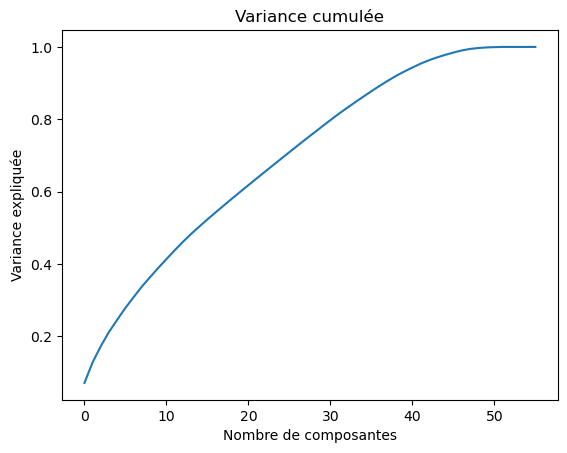

In [37]:
X_pca = PCA(random_state = 3).fit(X_pca_norm)


var_cumul = np.cumsum(X_pca.explained_variance_ratio_)
plt.plot(var_cumul)
plt.title('Variance cumulée')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée')
     


In [38]:
var_cumul[31]

0.8148543407294777

In [39]:
X_pca = np.dot(X_pca_norm.values, X_pca.components_[:31,:].T)
X_pca = pd.DataFrame(X_pca, columns=["PC%d" % (x + 1) for x in range(31)])
X_pca.head()
     


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
0,-1.710077,0.847167,1.096473,-0.784783,1.765245,0.288340,-1.269510,-0.235602,-1.169289,-0.129473,...,0.587722,-2.006317,-0.054242,-0.439183,-0.001993,-1.014023,0.929171,-0.396542,0.065237,-1.095161
1,-3.147234,0.559482,-3.315017,3.910842,0.284428,-1.416026,-1.720682,1.282080,-2.844764,1.031810,...,0.029492,0.149337,0.031051,0.124151,0.026448,-0.072047,0.093504,-0.084954,0.244112,-0.011810
2,-2.338387,-0.557997,0.155780,-1.435451,1.253883,-0.695475,-0.299339,-0.310183,-0.124121,0.172640,...,-0.358095,0.126619,-0.339029,0.132555,-0.003548,0.126154,-0.519732,-0.632493,-0.168101,0.390191
3,0.415047,0.698062,0.373702,0.917745,1.849962,1.468067,-0.226802,0.470373,0.581793,-0.081904,...,-0.460110,-2.599732,-0.653914,-0.993169,0.272897,0.342573,2.326095,-2.121878,0.151792,1.116529
4,-1.269739,0.819314,0.936312,-1.156285,1.153483,0.004570,-0.713935,0.014093,0.208930,2.230654,...,-0.332587,-0.054076,-0.152955,-0.192005,0.043192,-0.147338,0.056694,-0.959376,0.110961,0.475472


<a name="models"></a>
# Models 

#### Division du dataset en Train et Test

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 3)


### Suréchantillonnage aléatoire 

In [41]:
from imblearn.over_sampling import RandomOverSampler
x_train_s, y_train_s = RandomOverSampler(random_state = 3).fit_resample(x_train, y_train)

 ###  Naive Bayes
 
On commence d'abord par un simple modèle Naive Bayes 

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               740 non-null    int64   
 1   Reason for absence               740 non-null    int64   
 2   Month of absence                 740 non-null    int64   
 3   Day of the week                  740 non-null    int64   
 4   Seasons                          740 non-null    int64   
 5   Transportation expense           740 non-null    int64   
 6   Distance from Residence to Work  740 non-null    int64   
 7   Service time                     740 non-null    int64   
 8   Age                              740 non-null    int64   
 9   Work load Average/day            740 non-null    float64 
 10  Hit target                       740 non-null    int64   
 11  Disciplinary failure             740 non-null    int64   
 12  Educatio

In [43]:
model_NB = GaussianNB().fit(x_train_s,y_train_s)


In [44]:
y_pred = model_NB.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(accuracy)

45.94594594594595


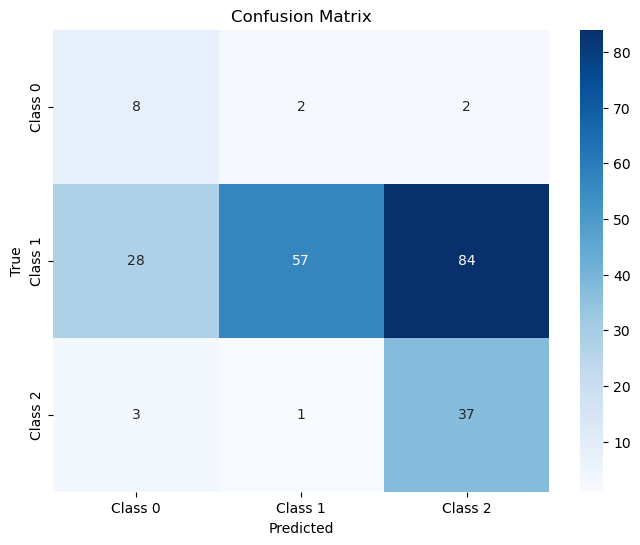

In [45]:
cm = confusion_matrix(y_test,y_pred)


# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:

#rapport de classification
print("Rapport de classification:\n ",classification_report(y_test,y_pred))


Rapport de classification:
                precision    recall  f1-score   support

 absenteiste       0.21      0.67      0.31        12
      normal       0.95      0.34      0.50       169
      retard       0.30      0.90      0.45        41

    accuracy                           0.46       222
   macro avg       0.49      0.64      0.42       222
weighted avg       0.79      0.46      0.48       222



### Modèle de Decison Tree

In [47]:
model = DecisionTreeClassifier(criterion = "gini" ).fit(x_train_s,y_train_s)

In [48]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_pred,y_test) * 100
print(accuracy)


76.57657657657657


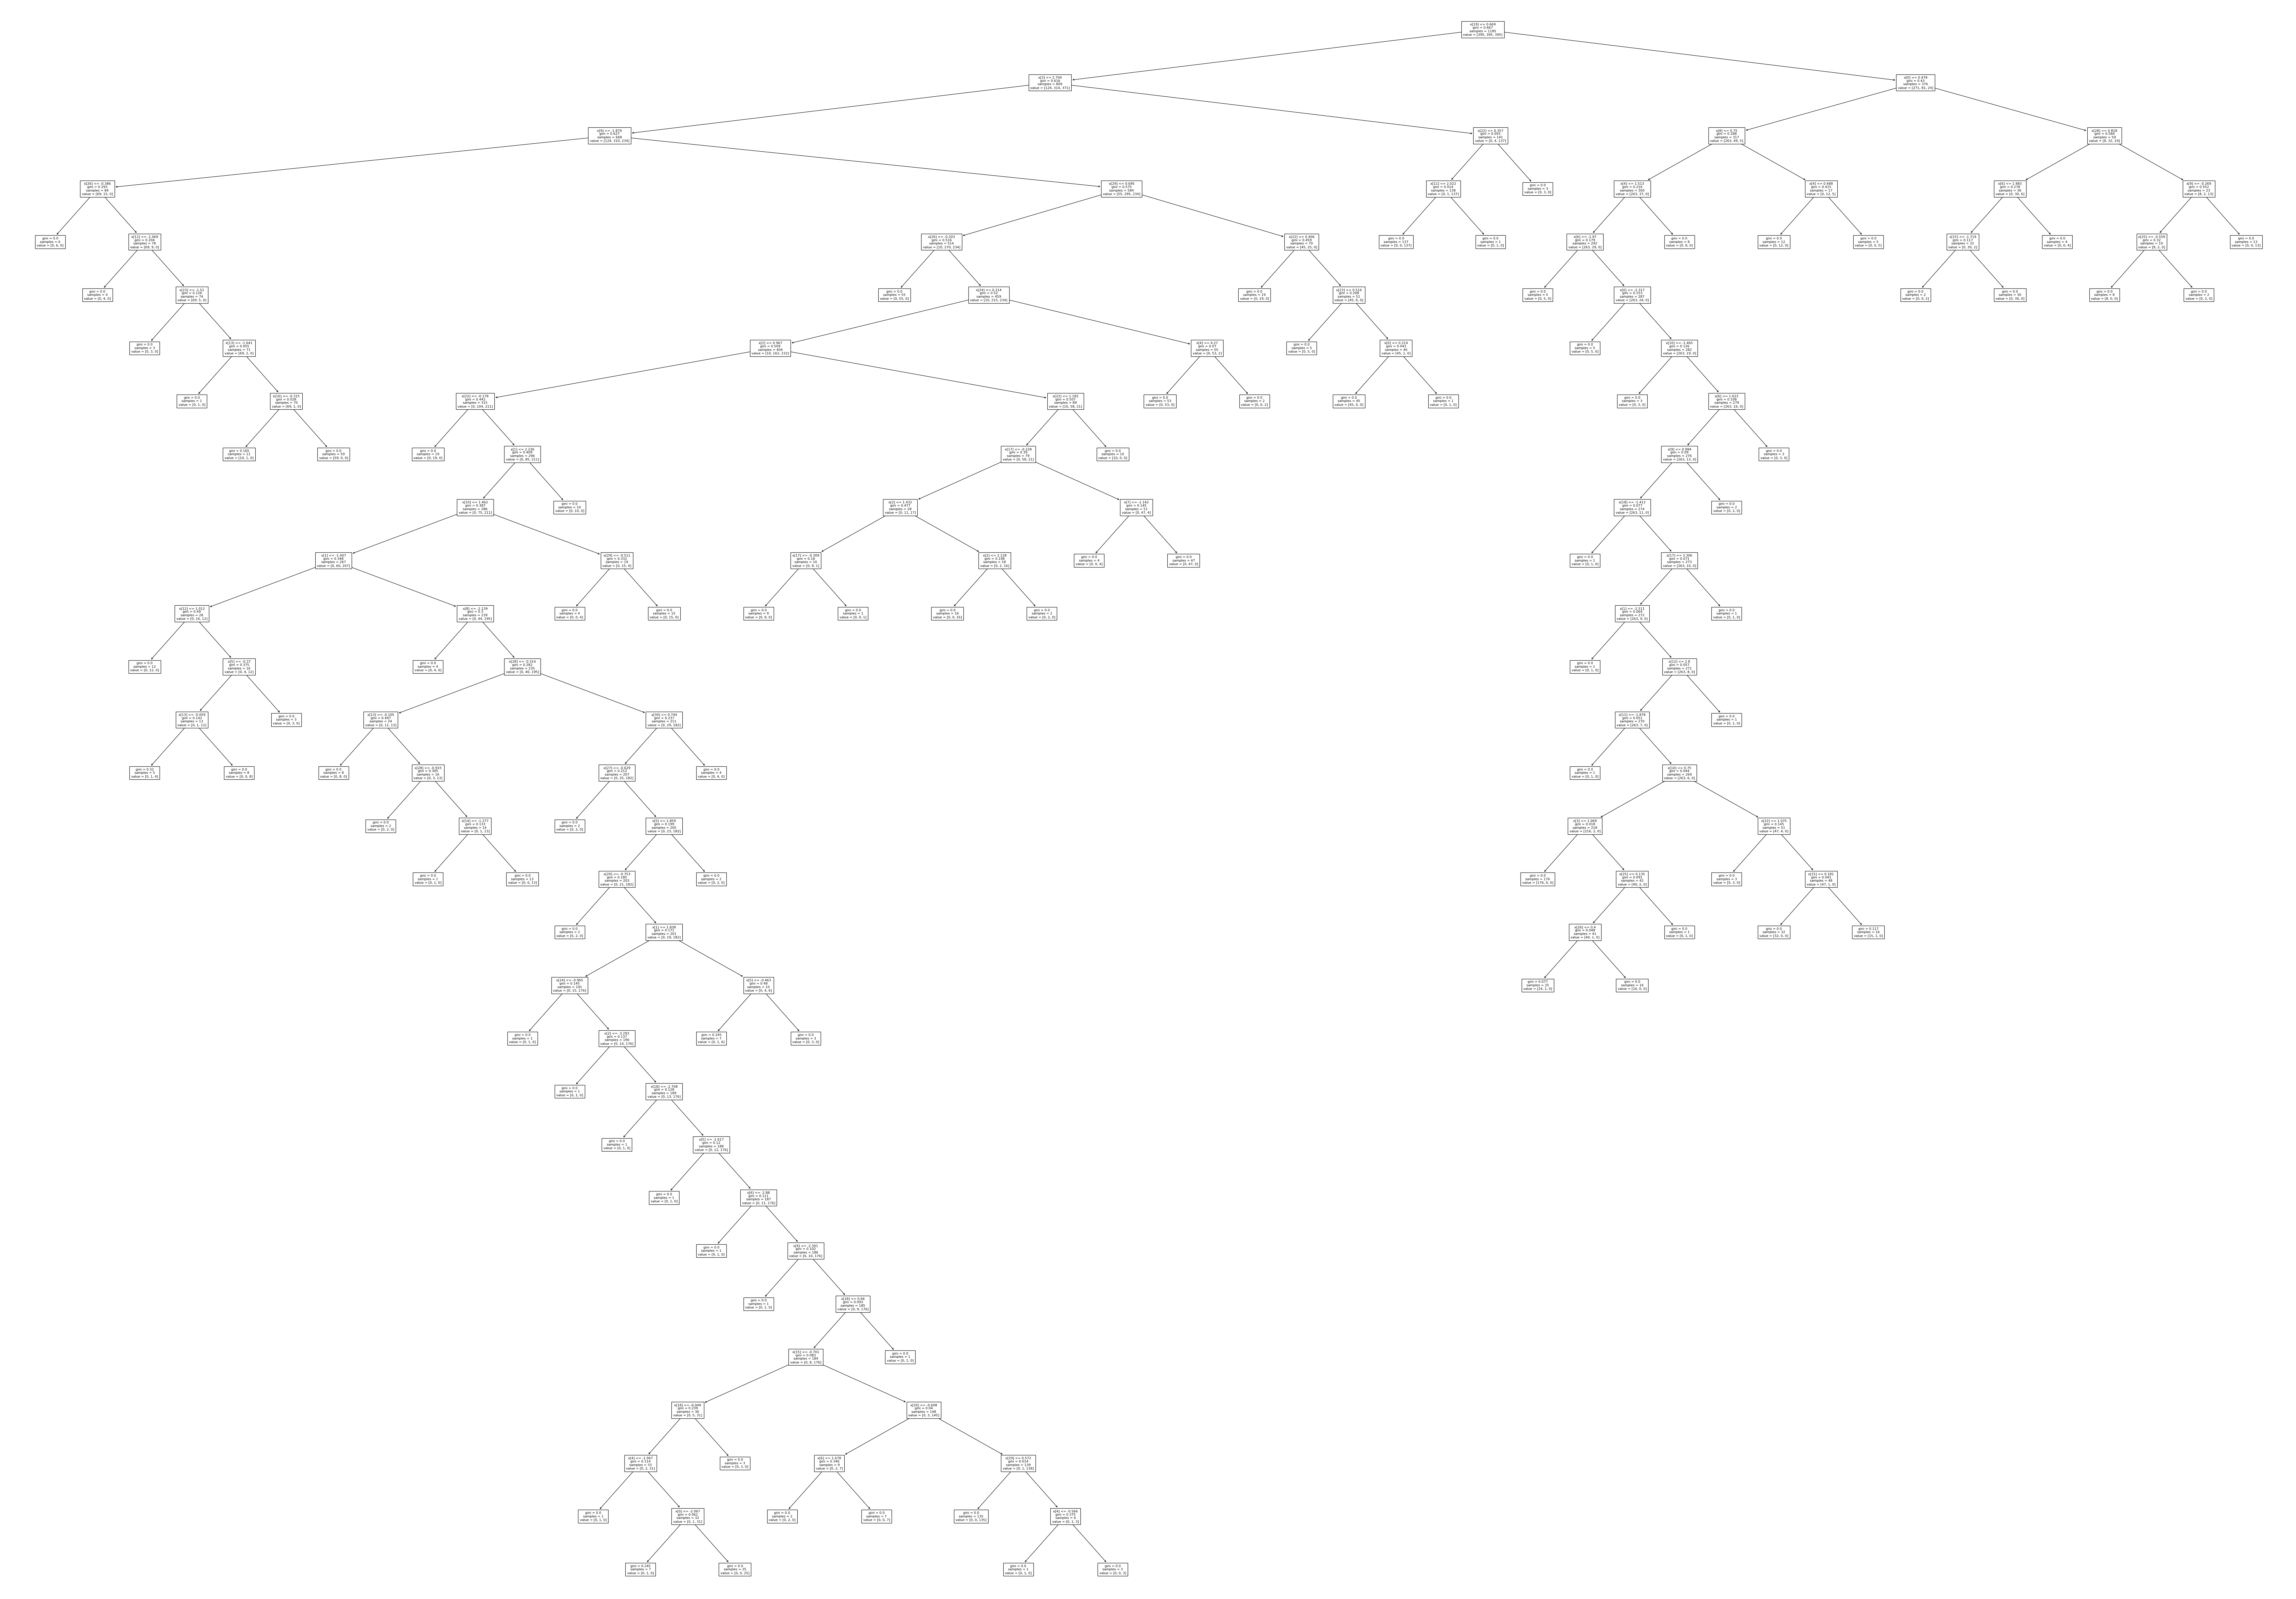

In [ ]:
plt.figure(figsize=(100,70)) 
plot_tree(model, fontsize=8)
plt.show()

[[  3   8   1]
 [  4 146  19]
 [  0  20  21]]


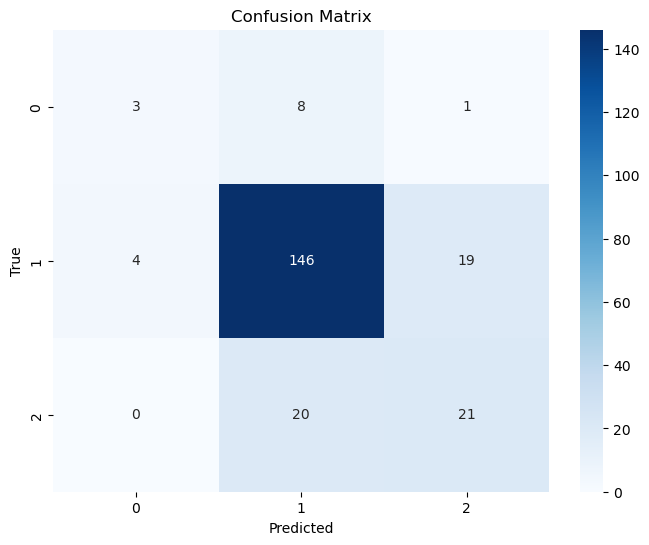

In [50]:
cm = confusion_matrix(y_test,y_pred)
print(cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print("Rapport de classification:\n ",classification_report(y_test,y_pred))

Rapport de classification:
                precision    recall  f1-score   support

 absenteiste       0.43      0.25      0.32        12
      normal       0.84      0.86      0.85       169
      retard       0.51      0.51      0.51        41

    accuracy                           0.77       222
   macro avg       0.59      0.54      0.56       222
weighted avg       0.76      0.77      0.76       222

